### 1. Import Libraries and Fetch Data

In [13]:
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

# Fetch historical data for the past two years up until 2024-02-09
end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

# Get historical data for AAPL
data = si.get_data('AAPL', start_date=start_date, end_date=end_date)

# Reset index to have a column with dates and rename it to 'date'
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)

display(data)


,date,open,high,low,close,adjclose,volume,ticker
0,2022-02-09,176.050003,176.649994,174.899994,176.279999,174.052216,71285000,AAPL
1,2022-02-10,174.139999,175.479996,171.550003,172.119995,169.944763,90865900,AAPL
2,2022-02-11,172.330002,173.080002,168.039993,168.639999,166.508774,98670700,AAPL
3,2022-02-14,167.369995,169.580002,166.559998,168.880005,166.745728,86185500,AAPL
4,2022-02-15,170.970001,172.949997,170.250000,172.789993,170.606293,62527400,AAPL
...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912384,53439000,AAPL


### 2. Calculate Technical Indicators - Feature Engineering

In [14]:
# Simple Moving Average (SMA)
data['SMA_10'] = data['close'].rolling(window=10).mean()

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['20_SMA'] = data['close'].rolling(window=20).mean()
data['20_std'] = data['close'].rolling(window=20).std()
data['Upper_Band'] = data['20_SMA'] + (data['20_std'] * 2)
data['Lower_Band'] = data['20_SMA'] - (data['20_std'] * 2)

# Create lagged closing prices
data['Close_1'] = data['close'].shift(1)
data['Close_2'] = data['close'].shift(2)

# Drop rows with NaN values (due to shifting and rolling calculations)
data.dropna(inplace=True)

display(data)

,date,open,high,low,close,adjclose,volume,ticker,SMA_10,RSI_14,20_SMA,20_std,Upper_Band,Lower_Band,Close_1,Close_2
19,2022-03-09,161.479996,163.410004,159.410004,162.949997,160.890671,91454900,AAPL,163.156000,37.179469,166.169501,4.873161,175.915822,156.423179,157.440002,159.300003
20,2022-03-10,160.199997,160.389999,155.979996,158.520004,156.516663,105342000,AAPL,162.734000,36.439778,165.281501,4.540624,174.362748,156.200254,162.949997,157.440002
21,2022-03-11,158.929993,159.279999,154.500000,154.729996,152.774551,96970100,AAPL,161.721999,34.446900,164.412001,4.818695,174.049391,154.774611,158.520004,162.949997
22,2022-03-14,151.449997,154.119995,150.100006,150.619995,148.716476,108732100,AAPL,160.271999,33.509847,163.511001,5.606782,174.724565,152.297437,154.729996,158.520004
23,2022-03-15,150.899994,155.570007,150.380005,155.089996,153.129974,92964300,AAPL,159.460999,44.037340,162.821500,5.757663,174.336826,151.306175,150.619995,154.729996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL,190.703998,49.883308,188.155998,4.309938,196.775873,179.536123,186.860001,184.399994
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL,190.082997,56.857413,188.480998,3.989362,196.459721,180.502275,185.850006,186.860001
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL,189.494998,60.960283,188.667999,3.932484,196.532967,180.803030,187.679993,185.850006
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912384,53439000,AAPL,188.985999,51.600984,188.881499,3.845821,196.573140,181.189857,189.300003,187.679993


### 3. Prepare Data for Prophet

In [17]:
# Prepare the DataFrame for Prophet
data_prophet = data[['date', 'close', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']].copy()
data_prophet.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)

# Normalize the additional regressors
data_prophet['SMA_10'] = (data_prophet['SMA_10'] - data_prophet['SMA_10'].mean()) / data_prophet['SMA_10'].std()
data_prophet['RSI_14'] = (data_prophet['RSI_14'] - data_prophet['RSI_14'].mean()) / data_prophet['RSI_14'].std()
data_prophet['Upper_Band'] = (data_prophet['Upper_Band'] - data_prophet['Upper_Band'].mean()) / data_prophet['Upper_Band'].std()
data_prophet['Lower_Band'] = (data_prophet['Lower_Band'] - data_prophet['Lower_Band'].mean()) / data_prophet['Lower_Band'].std()
data_prophet['Close_1'] = (data_prophet['Close_1'] - data_prophet['Close_1'].mean()) / data_prophet['Close_1'].std()
data_prophet['Close_2'] = (data_prophet['Close_2'] - data_prophet['Close_2'].mean()) / data_prophet['Close_2'].std()


### 4. Split Data into Training and Testing Sets

In [18]:
# Split the dataset into 80% training and 20% testing
train_size = int(len(data_prophet) * 0.8)
train = data_prophet[:train_size]
test = data_prophet[train_size:]
display(train.shape)
display(test.shape)

(386, 8)

(97, 8)

### 5. Hyperparameter Tuning

In [20]:
import logging
import warnings
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Ignore warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

param_grid = {
        'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
        'seasonality_prior_scale': [1.0, 2.0, 3.0, 4.0, 5.0],
}


all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []

# Iterate through each combination of parameters
for params in all_params:
    try:
        m = Prophet(**params)
        for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
            m.add_regressor(col)
        m.fit(train)
        
        # Cross-validation
        df_cv = cross_validation(m, initial='365 days', period='1 days', horizon='90 days', parallel="processes")
        
        # Performance metrics
        df_p = performance_metrics(df_cv)
        
        # Calculate additional metrics
        y_true = df_cv['y']
        y_pred = df_cv['yhat']
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        results.append({
            'params': params,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape
        })
        
        logging.info(f"Completed params: {params} with MAE: {mae}, RMSE: {rmse}, R-squared: {r2}, MAPE: {mape}")
    
    except Exception as e:
        logging.error(f"Error with params: {params} - {e}")
        results.append({
            'params': params,
            'mae': float('inf'),
            'rmse': float('inf'),
            'r2': float('-inf'),
            'mape': float('inf')
        })

# Compile results
tuning_results = pd.DataFrame(results)
best_params = tuning_results.loc[tuning_results['rmse'].idxmin()]

# Display results table
results_table = tuning_results[['params', 'mae', 'rmse', 'r2', 'mape']]
print("Best Parameters:", best_params)
display(results_table)

# Generate in-sample predictions using the best model
best_model = Prophet(**best_params['params'])
for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
    best_model.add_regressor(col)
best_model.fit(train)

future = best_model.make_future_dataframe(periods=0)
forecast = best_model.predict(future)

# Plot the fitted values
fig = best_model.plot(forecast)
plt.title('Prophet Model Fit on Training Data')
plt.show()

# Plot the model components (trend, seasonality, etc.)
fig2 = best_model.plot_components(forecast)
plt.show()


2024-06-07 19:41:51,764 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-06-07 19:41:51,852 - DEBUG - TBB already found in load path
2024-06-07 19:41:51,863 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-06-07 19:41:51,864 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-06-07 19:41:51,885 - DEBUG - input tempfile: C:\Users\kahbe\AppData\Local\Temp\tmpniv0szk9\hcrt67ix.json
2024-06-07 19:41:51,897 - DEBUG - input tempfile: C:\Users\kahbe\AppData\Local\Temp\tmpniv0szk9\9cmkkl3f.json
2024-06-07 19:41:51,900 - DEBUG - idx 0
2024-06-07 19:41:51,901 - DEBUG - running CmdStan, num_threads: None
2024-06-07 19:41:51,901 - DEBUG - CmdStan args: ['C:\\Users\\kahbe\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=27088', 'data', 'file=C:\\Users\\kahbe\\AppData\\Local\\Temp\\tmpniv0szk9\\hcrt67ix.json', 'init=C:\\Users\\kahbe\\AppData\\Local\\Temp\\tmpn

Best Parameters: params    {'changepoint_prior_scale': 0.05, 'seasonality...
mae                                                1.675285
rmse                                               2.134466
r2                                                 0.953454
mape                                               0.938064
Name: 6, dtype: object


,params,mae,rmse,r2,mape
0,"{'changepoint_prior_scale': 0.01, 'seasonality...",1.755382,2.194379,0.950804,0.982750
1,"{'changepoint_prior_scale': 0.01, 'seasonality...",1.754174,2.194089,0.950817,0.982117
2,"{'changepoint_prior_scale': 0.01, 'seasonality...",1.762713,2.204663,0.950342,0.987021
3,"{'changepoint_prior_scale': 0.01, 'seasonality...",1.757500,2.197472,0.950665,0.983991
4,"{'changepoint_prior_scale': 0.01, 'seasonality...",1.755892,2.197030,0.950685,0.983100
5,"{'changepoint_prior_scale': 0.05, 'seasonality...",1.678673,2.140205,0.953203,0.939951
6,"{'changepoint_prior_scale': 0.05, 'seasonality...",1.675285,2.134466,0.953454,0.938064
7,"{'changepoint_prior_scale': 0.05, 'seasonality...",1.676898,2.136096,0.953382,0.938938
8,"{'changepoint_prior_scale': 0.05, 'seasonality...",1.681165,2.141608,0.953142,0.941327
9,"{'changepoint_prior_scale': 0.05, 'seasonality...",1.683274,2.145199,0.952984,0.942495


2024-06-07 19:53:40,472 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-06-07 19:53:40,601 - DEBUG - TBB already found in load path
2024-06-07 19:53:40,619 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-06-07 19:53:40,620 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-06-07 19:53:40,650 - DEBUG - input tempfile: C:\Users\kahbe\AppData\Local\Temp\tmpniv0szk9\au_c7tyw.json
2024-06-07 19:53:40,674 - DEBUG - input tempfile: C:\Users\kahbe\AppData\Local\Temp\tmpniv0szk9\aln0fa39.json
2024-06-07 19:53:40,677 - DEBUG - idx 0
2024-06-07 19:53:40,678 - DEBUG - running CmdStan, num_threads: None
2024-06-07 19:53:40,679 - DEBUG - CmdStan args: ['C:\\Users\\kahbe\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=28520', 'data', 'file=C:\\Users\\kahbe\\AppData\\Local\\Temp\\tmpniv0szk9\\au_c7tyw.json', 'init=C:\\Users\\kahbe\\AppData\\Local\\Temp\\tmpn

ValueError: Regressor 'SMA_10' missing from dataframe

2024-06-07 19:56:13,262 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-06-07 19:56:13,384 - DEBUG - TBB already found in load path
2024-06-07 19:56:13,403 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-06-07 19:56:13,403 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-06-07 19:56:13,429 - DEBUG - input tempfile: C:\Users\kahbe\AppData\Local\Temp\tmpniv0szk9\5v1mgbah.json
2024-06-07 19:56:13,454 - DEBUG - input tempfile: C:\Users\kahbe\AppData\Local\Temp\tmpniv0szk9\7uzwgf8k.json
2024-06-07 19:56:13,456 - DEBUG - idx 0
2024-06-07 19:56:13,457 - DEBUG - running CmdStan, num_threads: None
2024-06-07 19:56:13,458 - DEBUG - CmdStan args: ['C:\\Users\\kahbe\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=35128', 'data', 'file=C:\\Users\\kahbe\\AppData\\Local\\Temp\\tmpniv0szk9\\5v1mgbah.json', 'init=C:\\Users\\kahbe\\AppData\\Local\\Temp\\tmpn

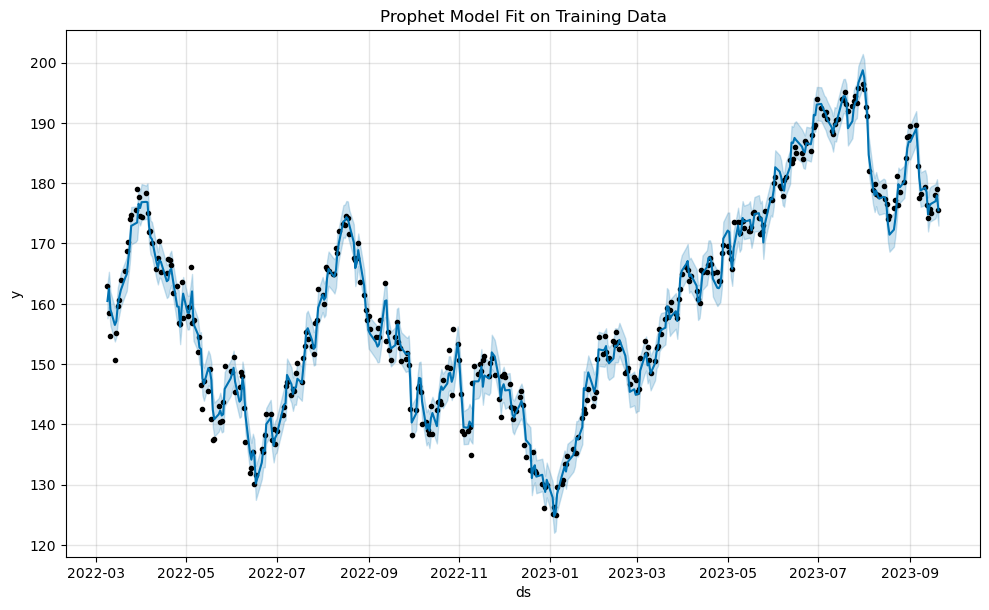

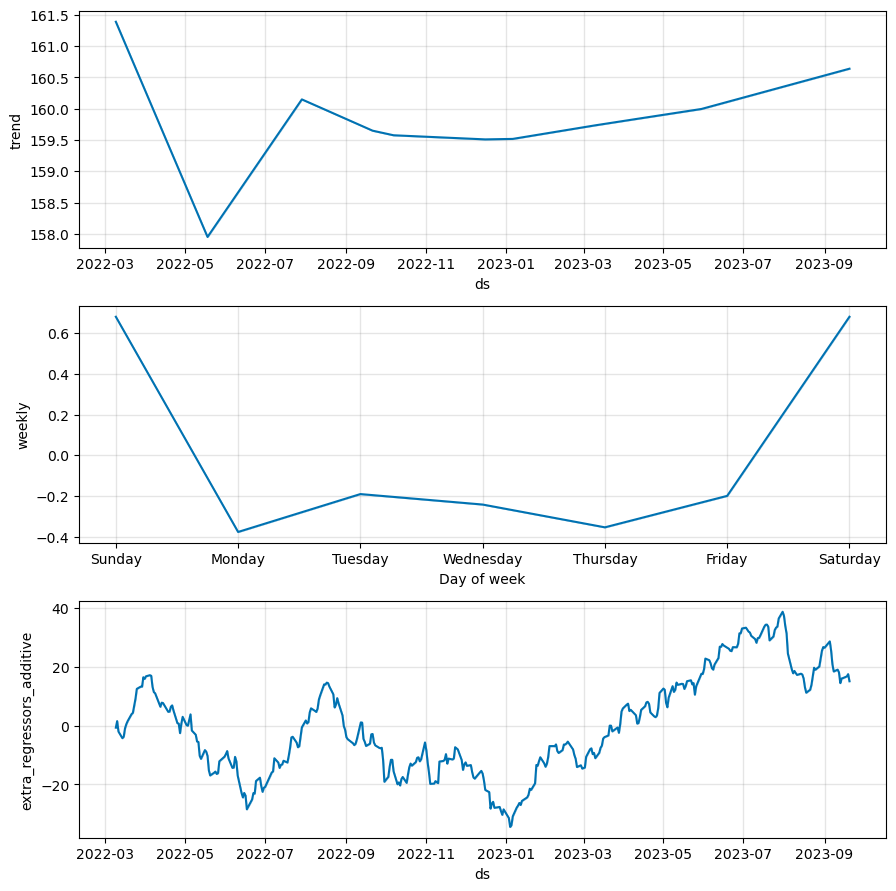

In [21]:
# Generate in-sample predictions using the best model
best_model = Prophet(**best_params['params'])
for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
    best_model.add_regressor(col)
best_model.fit(train)

# Create the future dataframe including the regressors
future = train[['ds', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']].copy()
forecast = best_model.predict(future)

# Plot the fitted values
fig = best_model.plot(forecast)
plt.title('Prophet Model Fit on Training Data')
plt.show()

# Plot the model components (trend, seasonality, etc.)
fig2 = best_model.plot_components(forecast)
plt.show()

In [26]:
display(tuning_results)
tuning_results.to_csv('prophet_tuning_results_narrowdown.csv', index=False)

,params,mae,rmse,r2,mape
0,"{'changepoint_prior_scale': 0.01, 'seasonality...",1.755382,2.194379,0.950804,0.982750
1,"{'changepoint_prior_scale': 0.01, 'seasonality...",1.754174,2.194089,0.950817,0.982117
2,"{'changepoint_prior_scale': 0.01, 'seasonality...",1.762713,2.204663,0.950342,0.987021
3,"{'changepoint_prior_scale': 0.01, 'seasonality...",1.757500,2.197472,0.950665,0.983991
4,"{'changepoint_prior_scale': 0.01, 'seasonality...",1.755892,2.197030,0.950685,0.983100
5,"{'changepoint_prior_scale': 0.05, 'seasonality...",1.678673,2.140205,0.953203,0.939951
6,"{'changepoint_prior_scale': 0.05, 'seasonality...",1.675285,2.134466,0.953454,0.938064
7,"{'changepoint_prior_scale': 0.05, 'seasonality...",1.676898,2.136096,0.953382,0.938938
8,"{'changepoint_prior_scale': 0.05, 'seasonality...",1.681165,2.141608,0.953142,0.941327
9,"{'changepoint_prior_scale': 0.05, 'seasonality...",1.683274,2.145199,0.952984,0.942495


### Testing Parameterss

In [23]:
# Step 4: Hyperparameter Tuning
param_grid = {
    'changepoint_prior_scale': [0.03, 0.035, 0.04, 0.045, 0.05],
    'seasonality_prior_scale': [2.0, 2.25, 2.5, 2.75, 3.0]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    m = Prophet(**params)
    for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
        m.add_regressor(col)
    m.fit(train)
    df_cv = cross_validation(m, initial='365 days', period='1 days', horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].mean())

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
best_params = tuning_results.loc[tuning_results['rmse'].idxmin()]
print("Best Parameters:", best_params)


2024-06-07 22:03:14,364 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-06-07 22:03:14,484 - DEBUG - TBB already found in load path
2024-06-07 22:03:14,521 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-06-07 22:03:14,522 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-06-07 22:03:14,555 - DEBUG - input tempfile: C:\Users\kahbe\AppData\Local\Temp\tmpniv0szk9\itap6qmf.json
2024-06-07 22:03:14,571 - DEBUG - input tempfile: C:\Users\kahbe\AppData\Local\Temp\tmpniv0szk9\t6l1smnl.json
2024-06-07 22:03:14,576 - DEBUG - idx 0
2024-06-07 22:03:14,577 - DEBUG - running CmdStan, num_threads: None
2024-06-07 22:03:14,577 - DEBUG - CmdStan args: ['C:\\Users\\kahbe\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=81358', 'data', 'file=C:\\Users\\kahbe\\AppData\\Local\\Temp\\tmpniv0szk9\\itap6qmf.json', 'init=C:\\Users\\kahbe\\AppData\\Local\\Temp\\tmpn

KeyboardInterrupt: 

In [ ]:
display(tuning_results)
tuning_results.to_csv('prophet_tuning_results_final.csv', index=False)

,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.030,2.00,2.130990
1,0.030,2.25,2.120057
2,0.030,2.50,2.121286
3,0.030,2.75,2.125614
4,0.030,3.00,2.127110
5,0.035,2.00,2.113031
6,0.035,2.25,2.109130
7,0.035,2.50,2.112114
8,0.035,2.75,2.112630
9,0.035,3.00,2.107946


### 6. Cross-Validation with Best Parameters

2024-06-07 22:04:16,695 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-06-07 22:04:16,779 - DEBUG - TBB already found in load path
2024-06-07 22:04:16,791 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-06-07 22:04:16,792 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-06-07 22:04:16,813 - DEBUG - input tempfile: C:\Users\kahbe\AppData\Local\Temp\tmpniv0szk9\xunitvib.json
2024-06-07 22:04:16,828 - DEBUG - input tempfile: C:\Users\kahbe\AppData\Local\Temp\tmpniv0szk9\_pwyf6_k.json
2024-06-07 22:04:16,830 - DEBUG - idx 0
2024-06-07 22:04:16,830 - DEBUG - running CmdStan, num_threads: None
2024-06-07 22:04:16,831 - DEBUG - CmdStan args: ['C:\\Users\\kahbe\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=92478', 'data', 'file=C:\\Users\\kahbe\\AppData\\Local\\Temp\\tmpniv0szk9\\xunitvib.json', 'init=C:\\Users\\kahbe\\AppData\\Local\\Temp\\tmpn

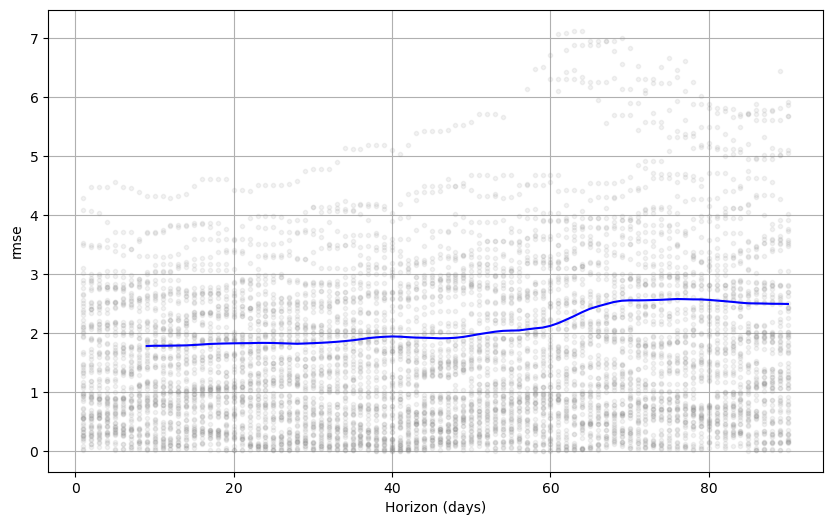

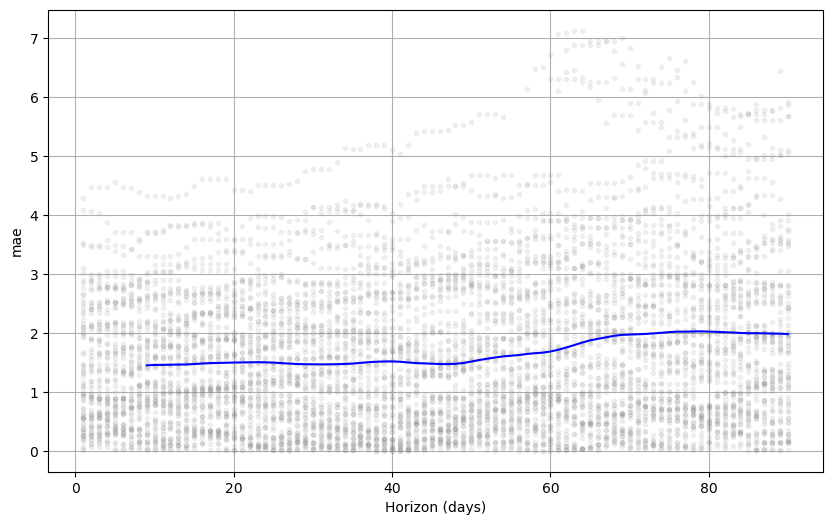

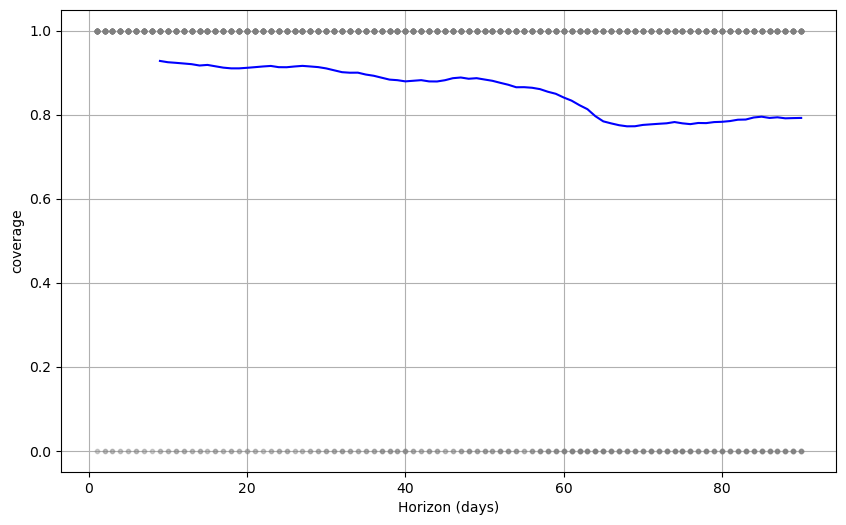

RMSE:


KeyError: 'rmse'

In [27]:
# model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
#                 seasonality_prior_scale=best_params['seasonality_prior_scale'])

model = Prophet(changepoint_prior_scale=0.05,
                seasonality_prior_scale=2.0)

for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
    model.add_regressor(col)
model.fit(train)

cv_results = cross_validation(model, initial='365 days', period='1 days', horizon='90 days', parallel="processes")

# Plot RMSE
fig = plot_cross_validation_metric(cv_results, metric='rmse')
plt.show()

# Plot MAE
fig = plot_cross_validation_metric(cv_results, metric='mae')
plt.show()

# Plot coverage
fig = plot_cross_validation_metric(cv_results, metric='coverage')
plt.show()



In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = mean_squared_error(cv_results['y'], cv_results['yhat'], squared=False)
print("RMSE:", rmse)

# Calculate MAE
mae = mean_absolute_error(cv_results['y'], cv_results['yhat'])
print("MAE:", mae)

# Calculate MAPE
mape = (abs(cv_results['y'] - cv_results['yhat']) / abs(cv_results['y'])).mean() * 100
print("MAPE:", mape)


RMSE: 2.134466023373284
MAE: 1.675285050899704
MAPE: 0.9380640913659998


### 7. Make Predictions

In [ ]:
# Step 7: Make Predictions
future = test[['ds']].copy()
for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
    future[col] = test[col]

forecast = model.predict(future)

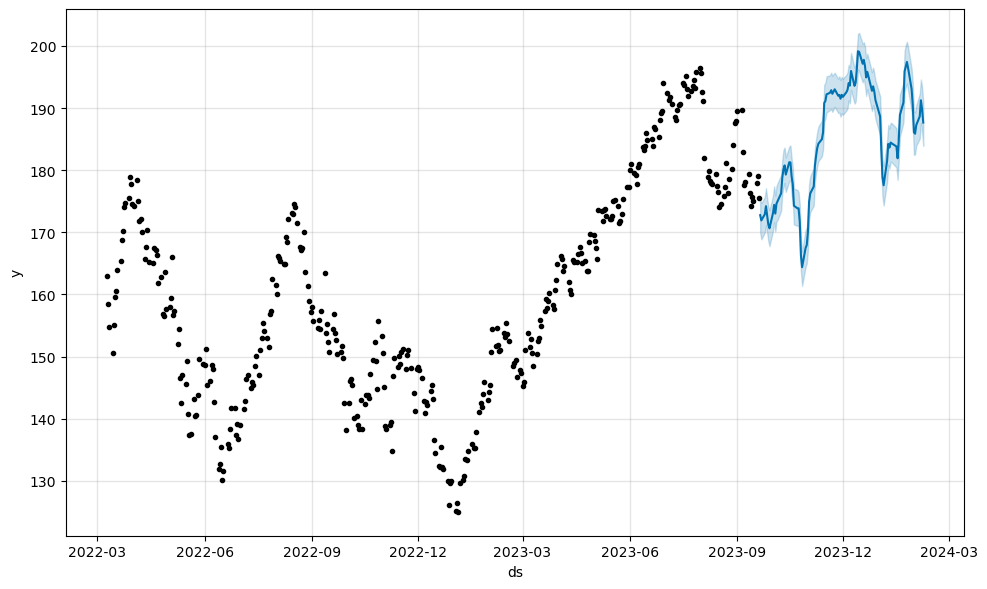

,ds,yhat,yhat_lower,yhat_upper,y
0,2023-09-21,172.764719,170.028297,175.286211,173.929993
1,2023-09-22,171.922826,168.873492,174.707205,174.789993
2,2023-09-25,172.910850,169.964062,175.675486,176.080002
3,2023-09-26,174.209528,171.120345,177.107104,171.960007
4,2023-09-27,172.695778,169.933345,175.524940,170.429993
...,...,...,...,...,...
92,2024-02-02,187.263138,183.962680,190.438595,185.850006
93,2024-02-05,188.663460,185.088703,192.294587,187.679993
94,2024-02-06,191.255340,187.583992,194.605708,189.300003
95,2024-02-07,189.841509,186.175214,193.394471,189.410004


In [ ]:
# Plot the forecast
model.plot(forecast)
plt.show()

# Merge the forecast with actual values from the test dataset
merged_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test[['ds', 'y']], on='ds')

# Display the merged DataFrame
display(merged_forecast)

### 8. Evaluate the Model


In [ ]:
y_true = test['y'].values
y_pred = forecast['yhat'].values

# Assuming y_true and y_pred are the actual and predicted values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

MAE: 1.6573448121100058
RMSE: 1.9874927427327844
R²: 0.943432818695411
MAPE: 0.9020927274473524


### 9. Results Visualisation

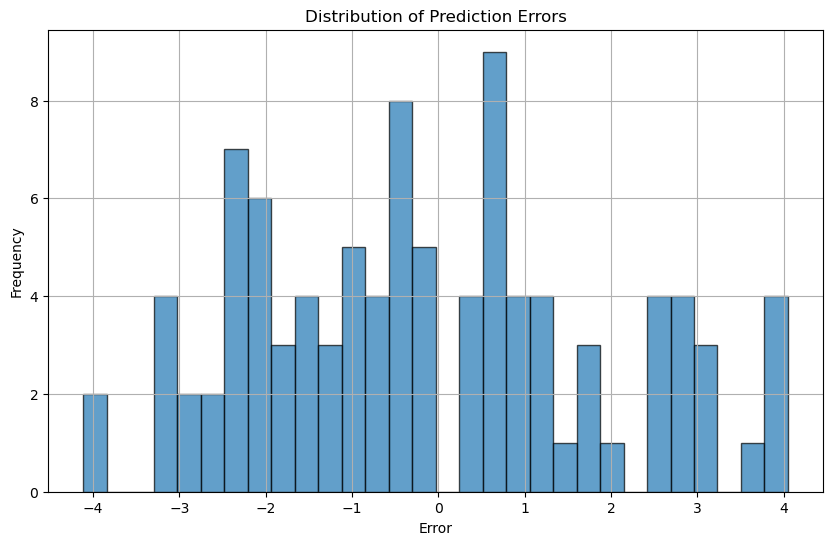

In [ ]:
# Residuals
residuals = y_true - y_pred

# Residual Plot
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

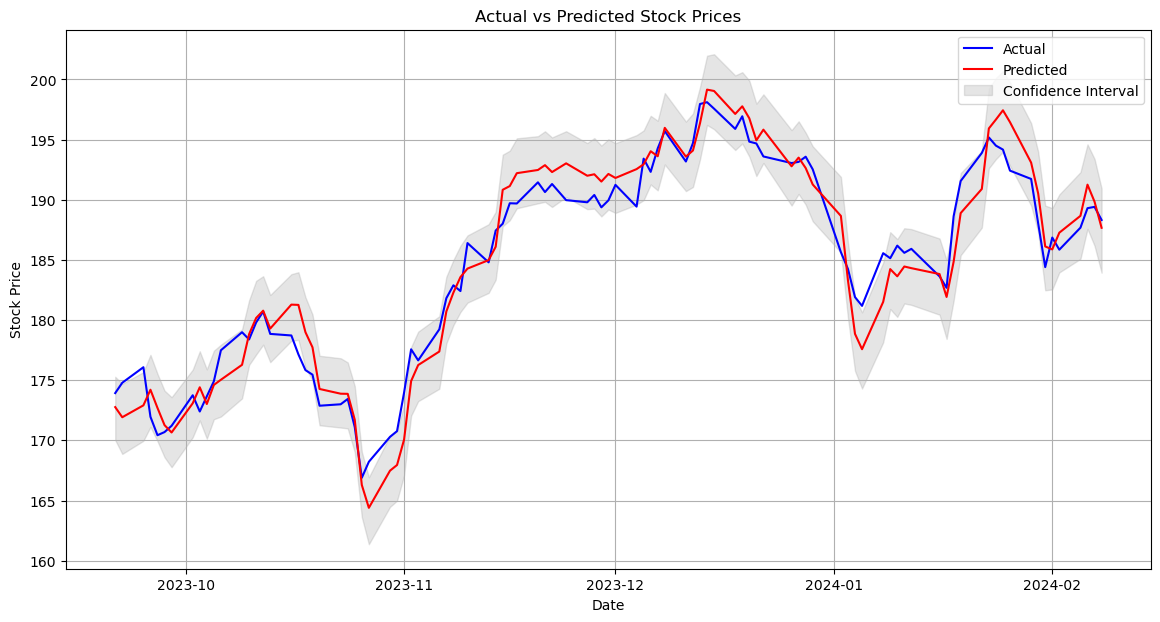

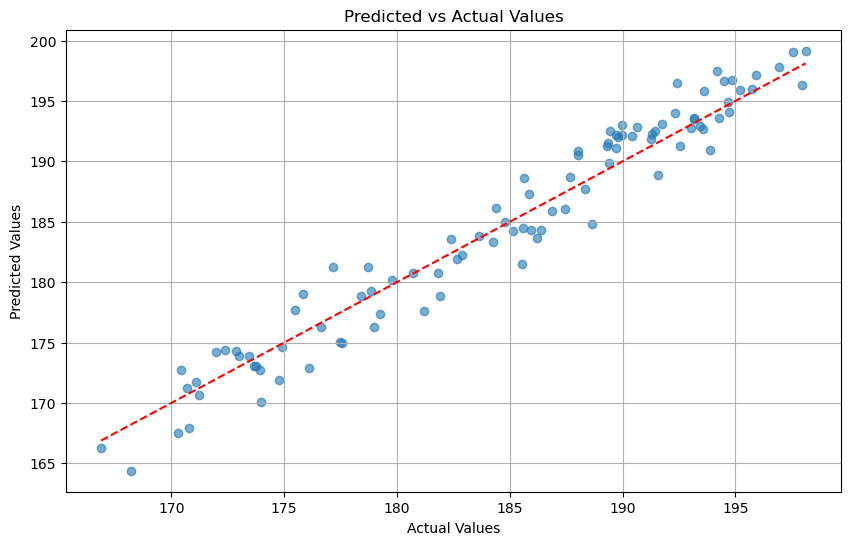

In [ ]:
# Actual vs Predicted plot
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_true, label='Actual', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted', color='red')
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
import joblib

# Save the model
joblib.dump(model, 'AAPL_prophet_model2.pkl')

['AAPL_prophet_model2.pkl']